In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import PROJECT.util as f
from matplotlib.pyplot import cm
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
import pandas as pd

In [49]:
# Pour des vecteurs u* et v*,
# les overlaps obtenus sont soit les deux positifs ou les deux négatifs, on a:
# overlap(u*)= -x et overlap(v*)= -y ou overlap(u*)= x et overlap(v*)= y.
# on prend donc le min(u-x, u+x):

# si u est positif et x est positif:
# min(u-x, u+x) -> u-x est bon

# si u est positif et x est négatif:
# min(u-(-x), u+(-x)) -> u+(-x) =u-x est bon

# si u est négatif et x est positif:
# min(-u-x, -u+x) -> -u+x =x-u est bon

# si u est négatif et x est négatif:
# min(-u-(-x), -u+(-x)) -> -u-(-x) =x-u est bon
def mse1(x,y):
    ## x-y
    a=torch.pow((x-y),2).mean(0)
    b=torch.pow((x+y),2).mean(0)
    return torch.min(a,b)
def mse2(u_e, v_e, u_t, v_t, Y):
    ## u*v*-uv
    tmp = torch.tensordot(u_e, v_e, 0) - torch.tensordot(u_t, v_t, 0)
    return torch.sum(torch.pow((tmp), 2))
def mse3(u_e, v_e, u_t, v_t, Y):
    ## Y-uv
    tmp = Y - torch.tensordot(u_t, v_t, 0)
    return torch.sum(torch.pow((tmp), 2))

In [61]:
def main_gradient_2_sans_proj_normalisation(iteration, u_p, v_p, Y, u_, v_, N, M, lambda_, beta_u, beta_v, lambda_1, lambda_2, dt):

    res = []
    res_mse= []
    
    mod = iteration*0.1
    
    stabilisation_check=np.empty((0,2))

    for i in range(iteration):

        # Computation
        sqrt_dt = torch.sqrt(dt)

        u_1 = (1/lambda_1) * f.gradient_u_2(N, M, u_p,v_p,Y,lambda_) * dt
        u_2 = torch.sqrt(2/(lambda_1*beta_u)) * torch.empty(N).normal_(mean=0,std=sqrt_dt)
        u_3 = ((N-1)/(N*lambda_1*beta_u))*u_p*dt
        u_n = u_p - u_1 + u_2 - u_3

        v_1 = 1/lambda_2 * f.gradient_v_2(N,M,u_p,v_p,Y,lambda_) * dt
        v_2 = torch.sqrt(2/(lambda_2*beta_v)) * torch.empty(M).normal_(mean=0,std=sqrt_dt)
        v_3 = ((M-1)/(M*lambda_2*beta_v))*v_p*dt
        v_n = v_p - v_1 + v_2 - v_3

        # Normalisation
        u_n = u_n / torch.linalg.norm(u_n)
        v_n = v_n / torch.linalg.norm(v_n)
        u_n = u_n * torch.sqrt(N)
        v_n = v_n * torch.sqrt(M)

        # Re-asign for the loop
        u_p = u_n
        v_p = v_n
    
        res_u = torch.abs(f.overlap(u_,u_n,N))
        res_v = torch.abs(f.overlap(v_,v_n,M))
        res.append((res_u,res_v))
        
        # CHOOSE BETWEEN MSE
        #res_mse.append((mse(u_,u_n),mse(v_,v_n)))
        res_mse.append((mse2(torch.abs(u_),torch.abs(v_),torch.abs(u_n),torch.abs(v_n),torch.abs(Y)),
                        mse2(torch.abs(u_),torch.abs(v_),torch.abs(u_n),torch.abs(v_n),torch.abs(Y))))
                       
        if i%mod==0:
            print(f"progress {100*i/iteration:.2f}%", end="\r")
        if i==iteration-1:
            print(f"overlap(u, v): ({res_u}; {res_v})")

    return np.array(res), np.array(res_mse)

In [65]:
def one_run(lambda_=2, N=200, M=200, beta_u=2, beta_v=2, lambda_1=1,
        lambda_2=1, dt=1/100, iteration=1000):
      #Size of the matrix Y
    N = torch.tensor(N)
    M = torch.tensor(M)

    # lambda
    lambda_ = torch.tensor(lambda_)

    #temperatures
    beta_u = torch.tensor(beta_u)
    beta_v = torch.tensor(beta_v)

    #learning rates
    lambda_1 = torch.tensor(lambda_1)
    lambda_2 = torch.tensor(lambda_2)

    # Pas de temps
    dt = torch.tensor(dt)

    u_ = f.generate_vector(N)
    v_ = f.generate_vector(M)

    Y = f.generate_Y(N, M, u_,v_, lambda_)
    #print(Y)

    # Conditions initiales
    u_p = f.generate_vector(N)
    v_p = f.generate_vector(M)

    # Perform the gradient descent
    (res, res_mse) = main_gradient_2_sans_proj_normalisation(iteration, u_p, v_p, Y, u_, v_, N, M, lambda_, beta_u, beta_v, lambda_1, lambda_2, dt)
    
    return res, res_mse


In [66]:
# MAIN METHOD:

def main(lambda_u_val, lambda_v_val, size_of_one_sample, list_value_1, list_value_2):
    
    all_overlap_iterations=[]
    all_final_overlaps=[]
    
    all_mse_iterations=[]
    all_final_mse=[]
    
    for value_to_test_1 in list_value_1:
        
        for value_to_test_2 in list_value_2:
        
            one_run_overlap_iterations=[]
            one_run_mse_iterations=[]

            # Calculation
            for _ in range(size_of_one_sample):
                (current_uv_overlap,current_uv_mse)=one_run(lambda_1=lambda_u_val, lambda_2=lambda_v_val,
                                                    beta_u=value_to_test_1, beta_v=value_to_test_2)
                # Store the overlap at the end of each iterations:
                one_run_overlap_iterations.append(current_uv_overlap)
                # Store the mse at the end of each iterations:
                one_run_mse_iterations.append(current_uv_mse)

            # Store the overlap/mse at the final iteration:
            one_run_final_overlap = np.array([x[-1] for x in one_run_overlap_iterations])
            one_run_final_mse = np.array([x[-1] for x in one_run_mse_iterations])

            # Add the results of this specific run to the global array:
            # overlap at all iterations:
            all_overlap_iterations.append(one_run_overlap_iterations)
            # overlap at the final iteration:
            all_final_overlaps.append(one_run_final_overlap)
            # mse at all iterations:
            all_mse_iterations.append(one_run_mse_iterations)
            # mse at the final iteration:
            all_final_mse.append(one_run_final_mse)
            
    return np.array(all_overlap_iterations), np.array(all_final_overlaps), np.array(all_mse_iterations), np.array(all_final_mse)

In [69]:
# MAIN CELL: DO THE COMPUTATION

## CHO0SE MSE IN THE SECOND CELL

lambda_u_val_1 = 1
lambda_v_val_1 = 1

list_value_1 = np.logspace(-1,0.5, 10)
#list_value_1 = np.arange(0.1, 1, 0.1)
#list_value_1 = np.array([1])

list_value_2 = np.logspace(-1,0.5, 10)
#list_value_2 = np.arange(0.1, 1, 0.1)
#list_value_2 = np.array([1])

size_of_one_sample=1

(overlap_at_each_iterations, overlap_at_final_iteration,
 mse_at_each_iterations, mse_at_final_iteration) = main(lambda_u_val_1, lambda_v_val_1,
                                            size_of_one_sample, list_value_1, list_value_2)

overlap(u, v): (0.055075254291296005; 0.030532212927937508)


KeyboardInterrupt: 

In [70]:
# MAIN CELL 2: DO THE COMPUTATION

## CHO0SE MSE IN THE SECOND CELL

lambda_u_val_2 = 1
lambda_v_val_2 = 0.01

size_of_one_sample=1

(overlap_at_each_iterations_2, overlap_at_final_iteration_2,
 mse_at_each_iterations_2, mse_at_final_iteration_2) = main(lambda_u_val_2, lambda_v_val_2,
                                                        size_of_one_sample, list_value_1, list_value_2)

overlap(u, v): (0.019400743767619133; 0.010840661823749542)
overlap(u, v): (0.06011385843157768; 0.0687636286020279)
overlap(u, v): (0.07541748881340027; 0.14221253991127014)


KeyboardInterrupt: 

In [73]:
name_value_1="beta_u"
name_value_2="beta_v"

name_n_1="500"
name_m_1="500"

name_n_2="500"
name_m_2="500"

# var = mean(abs(a - a.mean())**2).

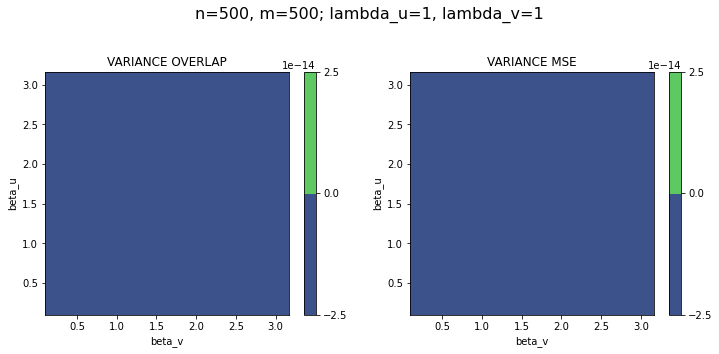

In [74]:
## HEAT MAP VARIANCE RUN 1
variance_map = np.var(overlap_at_final_iteration.mean(axis=2), axis=1)
variance_map = variance_map.reshape(len(list_value_1),len(list_value_2))

variance_mse_map = np.var(mse_at_final_iteration.mean(axis=2), axis=1)
variance_mse_map = variance_mse_map.reshape(len(list_value_1),len(list_value_2))

x, y = np.meshgrid(list_value_2,list_value_1)

fig,ax=plt.subplots(1,2, figsize=(12,5), facecolor='white')
#fig.tight_layout()
fig.subplots_adjust(top=0.8)
fig.suptitle(f"n={name_n_1}, m={name_m_1}; lambda_u={lambda_u_val_1}, lambda_v={lambda_v_val_1}", size=16)

bar0=ax[0].contourf(x,y, variance_map)
ax[0].set_title("VARIANCE OVERLAP")
ax[0].set_xlabel(f"{name_value_2}")
ax[0].set_ylabel(f"{name_value_1}")

bar1 = ax[1].contourf(x,y, variance_mse_map)
ax[1].set_title("VARIANCE MSE")
ax[1].set_xlabel(f"{name_value_2}")
ax[1].set_ylabel(f"{name_value_1}")

plt.colorbar(bar0, ax=ax[0])
plt.colorbar(bar1, ax=ax[1])

path=f"C:/Users/Admin/Desktop/n={name_n_1}_m={name_m_1}_lu={lambda_u_val_1}_lv={lambda_v_val_1}_variance.jpg"
plt.savefig(path)

plt.show()

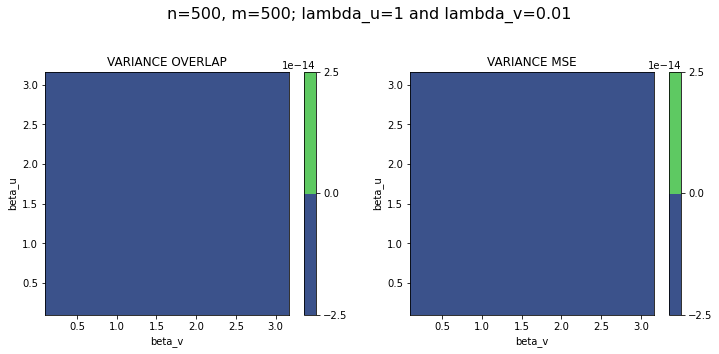

In [75]:
## HEAT MAP VARIANCE RUN 2
variance_map = np.var(overlap_at_final_iteration_2.mean(axis=2), axis=1)
variance_map = variance_map.reshape(len(list_value_1),len(list_value_2))

variance_mse_map = np.var(mse_at_final_iteration_2.mean(axis=2), axis=1)
variance_mse_map = variance_mse_map.reshape(len(list_value_1),len(list_value_2))

x, y = np.meshgrid(list_value_2,list_value_1)

fig,ax=plt.subplots(1,2, figsize=(12,5), facecolor='white')
#fig.tight_layout()
fig.subplots_adjust(top=0.8)
fig.suptitle(f"n={name_n_2}, m={name_m_2}; lambda_u={lambda_u_val_2} and lambda_v={lambda_v_val_2}", size=16)

bar0=ax[0].contourf(x,y, variance_map)
ax[0].set_title("VARIANCE OVERLAP")
ax[0].set_xlabel(f"{name_value_2}")
ax[0].set_ylabel(f"{name_value_1}")

bar1 = ax[1].contourf(x,y, variance_mse_map)
ax[1].set_title("VARIANCE MSE")
ax[1].set_xlabel(f"{name_value_2}")
ax[1].set_ylabel(f"{name_value_1}")

plt.colorbar(bar0, ax=ax[0])
plt.colorbar(bar1, ax=ax[1])

path=f"C:/Users/Admin/Desktop/n={name_n_2}_m={name_m_2}_lu={lambda_u_val_2}_lv={lambda_v_val_2}_variance.jpg"
plt.savefig(path)

plt.show()

In [76]:
######################### 3D PLOT BOTH CONFIG

x, y = np.meshgrid(list_value_2,list_value_1)
overlap_mean=overlap_at_final_iteration.mean(axis=1).mean(axis=1)
overlap_mean=overlap_mean.reshape(len(list_value_1),len(list_value_2))

overlap_mean_2=overlap_at_final_iteration_2.mean(axis=1).mean(axis=1)
overlap_mean_2=overlap_mean_2.reshape(len(list_value_1),len(list_value_2))

fig = go.Figure(data=[
    go.Surface(name=f"n={name_n_1}, m={name_m_1}; lu={lambda_u_val_1}, lv={lambda_v_val_1}",
               z=overlap_mean,x=list_value_1, y=list_value_2,
               colorscale ='Blues', showscale=False, opacity=1),
    go.Surface(name=f"n={name_n_2}, m={name_m_2}; lu={lambda_u_val_2}, lv={lambda_v_val_2}",
               z=overlap_mean_2,x=list_value_1, y=list_value_2,
               colorscale ='Greens', showscale=False, opacity=0.9)])

fig.update_layout(
    title=f"OVERLAP:",
)

fig.update_layout(showlegend=True, scene = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="overlap"))
fig.update_traces(showlegend=True)

fig.show()
path=f"C:/Users/Admin/Desktop/R1_n={name_n_1}_m={name_m_1}_"\
f"Ldiff={lambda_u_val_1/lambda_v_val_1}_"\
f"R2_n={name_n_2}_m={name_m_2}_"\
f"Ldiff={lambda_u_val_2/lambda_v_val_2}_overlap.html"
fig.write_html(path)

In [22]:
######################### 3D PLOT BOTH CONFIG
#### MSE
x, y = np.meshgrid(list_value_2,list_value_1)
mse_mean=mse_at_final_iteration.mean(axis=1).mean(axis=1)
mse_mean=mse_mean.reshape(len(list_value_1),len(list_value_2))

mse_mean_2=mse_at_final_iteration_2.mean(axis=1).mean(axis=1)
mse_mean_2=mse_mean_2.reshape(len(list_value_1),len(list_value_2))

fig = go.Figure(data=[
    go.Surface(name=f"n={name_n_1}, m={name_m_1}; lu={lambda_u_val_1}, lv={lambda_v_val_1}",
               z=mse_mean,x=list_value_1, y=list_value_2,
               colorscale ='Blues', showscale=False, opacity=1),
    go.Surface(name=f"n={name_n_2}, m={name_m_2}; lu={lambda_u_val_2}, lv={lambda_v_val_2}",
               z=mse_mean_2,x=list_value_1, y=list_value_2,
               colorscale ='Greens', showscale=False, opacity=0.9)])

fig.update_layout(
    title=f"MSE:",
)
fig.update_layout(scene = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="mse"))
fig.update_traces(showlegend=True)

fig.show()
path=f"C:/Users/Admin/Desktop/R1_n={name_n_1}_m={name_m_1}_"\
f"Ldiff={lambda_u_val_1/lambda_v_val_1}_"\
f"R2_n={name_n_2}_m={name_m_2}_"\
f"Ldiff={lambda_u_val_2/lambda_v_val_2}_mse.html"
fig.write_html(path)

In [47]:
# OVERLAP AND MSE RUN 1

from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'surface'}, {'type': 'surface'}]])
fig.add_trace(go.Surface(z=overlap_mean, x=list_value_2, y=list_value_1,
                         name="overlap", showscale=False),
             row=1, col=1)
fig.add_trace(go.Surface(z=mse_mean, x=list_value_2, y=list_value_1,
                         name="mse", showscale=False, colorscale ='viridis'),
             row=1, col=2)

fig.update_layout(scene = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="overlap"),
                  scene2 = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="mse"),
               autosize=False, width=1000, height=500)

fig.update_traces(showlegend=True)

fig.show()
path=f"C:/Users/Admin/Desktop/n={name_n_1}_m={name_m_1}_lu={lambda_u_val_1}_lv={lambda_v_val_1}.html"
fig.write_html(path)

In [239]:
# OVERLAP AND MSE RUN 2

from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'surface'}, {'type': 'surface'}]])
fig.add_trace(go.Surface(z=overlap_mean_2, x=list_value_2, y=list_value_1,
                         name="overlap", showscale=False),
             row=1, col=1)
fig.add_trace(go.Surface(z=mse_mean_2, x=list_value_2, y=list_value_1,
                         name="mse", showscale=False, colorscale ='viridis'),
             row=1, col=2)

fig.update_layout(
    title=f"n={name_n_2}, m={name_m_2}; lu={lambda_u_val_2}, lv={lambda_v_val_2}",
)
fig.update_layout(scene = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="overlap"),
                  scene2 = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="mse"),
               autosize=False, width=1000, height=500)
fig.update_traces(showlegend=True)

fig.show()
path=f"C:/Users/Admin/Desktop/n={name_n_2}_m={name_m_2}_lu={lambda_u_val_2}_lv={lambda_v_val_2}.html"
fig.write_html(path)

In [246]:
# OVERLAP AND MSE RUN 1 _ U et V séparés!

from plotly.subplots import make_subplots

array_u_overlap, array_v_overlap=overlap_at_final_iteration.mean(axis=1).T

array_u_overlap=array_u_overlap.reshape(len(list_value_1),len(list_value_2))
array_v_overlap=array_v_overlap.reshape(len(list_value_1),len(list_value_2))
#array_v_overlap=array_v_overlap+0.1

array_u_mse, array_v_mse=mse_at_final_iteration.mean(axis=1).T

array_u_mse=array_u_mse.reshape(len(list_value_1),len(list_value_2))
array_v_mse=array_v_mse.reshape(len(list_value_1),len(list_value_2))
#array_v_mse=array_v_mse+0.1

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'surface'}, {'type': 'surface'}]])
fig.add_trace(go.Surface(z=array_u_overlap, x=list_value_2, y=list_value_1,
                         name="overlap_u", showscale=False),
             row=1, col=1)
fig.add_trace(go.Surface(z=array_v_overlap, x=list_value_2, y=list_value_1,
                         name="overlap_v", showscale=False, opacity=0.9),
             row=1, col=1)

fig.add_trace(go.Surface(z=array_u_mse, x=list_value_2, y=list_value_1,
                         name="mse_u", showscale=False, colorscale ='viridis'),
             row=1, col=2)
fig.add_trace(go.Surface(z=array_v_mse, x=list_value_2, y=list_value_1,
                         name="mse_v", showscale=False, colorscale ='viridis', opacity=0.9),
             row=1, col=2)

fig.update_layout(
    title=f"n={name_n_1}, m={name_m_1}; lu={lambda_u_val_1}, lv={lambda_v_val_1}",
)
fig.update_layout(scene = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="overlap"),
                  scene2 = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="mse"),
               autosize=False, width=1000, height=500)
fig.update_traces(showlegend=True)

fig.show()
path=f"C:/Users/Admin/Desktop/n={name_n_1}_m={name_m_1}_lu={lambda_u_val_1}_lv={lambda_v_val_1}_uv.html"
fig.write_html(path)

In [243]:
# OVERLAP AND MSE RUN 2 _ U et V séparés!

from plotly.subplots import make_subplots

array_u_overlap, array_v_overlap=overlap_at_final_iteration_2.mean(axis=1).T

array_u_overlap=array_u_overlap.reshape(len(list_value_1),len(list_value_2))
array_v_overlap=array_v_overlap.reshape(len(list_value_1),len(list_value_2))
#array_v_overlap=array_v_overlap+0.1

array_u_mse, array_v_mse=mse_at_final_iteration_2.mean(axis=1).T

array_u_mse=array_u_mse.reshape(len(list_value_1),len(list_value_2))
array_v_mse=array_v_mse.reshape(len(list_value_1),len(list_value_2))
#array_v_mse=array_v_mse+0.1

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'surface'}, {'type': 'surface'}]])
fig.add_trace(go.Surface(z=array_u_overlap, x=list_value_2, y=list_value_1,
                         name="overlap_u", showscale=False),
             row=1, col=1)
fig.add_trace(go.Surface(z=array_v_overlap, x=list_value_2, y=list_value_1,
                         name="overlap_v", showscale=False, opacity=0.9),
             row=1, col=1)

fig.add_trace(go.Surface(z=array_u_mse, x=list_value_2, y=list_value_1,
                         name="mse_u", showscale=False, colorscale ='viridis'),
             row=1, col=2)
fig.add_trace(go.Surface(z=array_v_mse, x=list_value_2, y=list_value_1,
                         name="mse_v", showscale=False,colorscale ='viridis', opacity=0.9),
             row=1, col=2)

fig.update_layout(
    title=f"n={name_n_2}, m={name_m_2}; lu={lambda_u_val_2}, lv={lambda_v_val_2}",
)
fig.update_layout(scene = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="overlap"),
                  scene2 = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="mse"),
               autosize=False, width=1000, height=500)
fig.update_traces(showlegend=True)

fig.show()
path=f"C:/Users/Admin/Desktop/n={name_n_2}_m={name_m_2}_lu={lambda_u_val_2}_lv={lambda_v_val_2}_uv.html"
fig.write_html(path)

In [ ]:
                                    ####################
                                    ##### OLD GRAPH ####
                                    ####################

In [6]:
######################### 3D PLOT OVERLAP AVEC PLOTLY
# U et V séparés!
array_u, array_v=overlap_at_final_iteration.mean(axis=1).T

array_u=array_u.reshape(len(list_value_1),len(list_value_2))
array_v=array_v.reshape(len(list_value_1),len(list_value_2))
array_v=array_v+0.1

fig = go.Figure(data=[
    go.Surface(z=array_u,x=list_value_1, y=list_value_2),
    go.Surface(z=array_v,x=list_value_1, y=list_value_2,showscale=False, opacity=0.9)])

fig.update_layout(
    title="OVERLAP: ",
)
fig.update_layout(scene = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="overlap"))

fig.show()
fig.write_html("C:/Users/Admin/Desktop/overlap_uv.html")

NameError: name 'overlap_at_final_iteration' is not defined

In [7]:
######################### 3D PLOT MSE AVEC PLOTLY
mse_mean=mse_at_final_iteration.mean(axis=1).mean(axis=1)
x, y = np.meshgrid(list_value_2,list_value_1)
mse_mean=mse_mean.reshape(len(list_value_1),len(list_value_2))

fig = go.Figure(data=[go.Surface(z=mse_mean, x=list_value_2, y=list_value_1)])

fig.update_layout(
    title="MSE: ",
)
fig.update_layout(scene = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="mse"))

fig.show()
fig.write_html("C:/Users/Admin/Desktop/mse.html")

NameError: name 'mse_at_final_iteration' is not defined

In [8]:
######################### 3D PLOT MSE AVEC PLOTLY
# U et V séparés!
array_u, array_v=mse_at_final_iteration.mean(axis=1).T

array_u=array_u.reshape(len(list_value_1),len(list_value_2))
array_v=array_v.reshape(len(list_value_1),len(list_value_2))
array_v=array_v+0.1

fig = go.Figure(data=[
    go.Surface(z=array_u,x=list_value_1, y=list_value_2),
    go.Surface(z=array_v,x=list_value_1, y=list_value_2,showscale=False, opacity=0.9)])

fig.update_layout(
    title="MSE: ",
)
fig.update_layout(scene = dict(
                    xaxis_title=name_value_2,
                    yaxis_title=name_value_1,
                    zaxis_title="mse"))

fig.show()
fig.write_html("C:/Users/Admin/Desktop/mse_uv.html")

NameError: name 'mse_at_final_iteration' is not defined

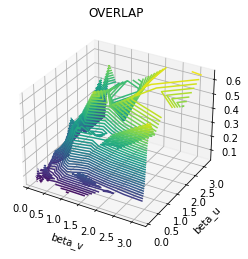

In [127]:
# overlap_at_each_iterations = FIRST CONFIG
# overlap_at_each_iterations_2 = SECOND CONFIG

######################### 3D PLOT OVERLAP
x, y = np.meshgrid(list_value_2,list_value_1)
overlap_mean=overlap_at_final_iteration.mean(axis=1).mean(axis=1)
overlap_mean=overlap_mean.reshape(len(list_value_1),len(list_value_2))

fig=plt.figure(facecolor='white')
ax=plt.axes(projection='3d')
ax.contour3D(x,y,overlap_mean, 50)

ax.set_title("OVERLAP")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

plt.show()

In [ ]:
# overlap_at_each_iterations = FIRST CONFIG
# overlap_at_each_iterations_2 = SECOND CONFIG

# STABILISATION OVERLAP AVEC PLOTLY
# CHANGER SELECTED_RUN !
selected_run=0

var_u,var_v=np.var(overlap_at_each_iterations[selected_run], axis=0).T
overlap_u,overlap_v=overlap_at_each_iterations.mean(1)[selected_run].T

x=[i for i in range(len(overlap_u))]

fig=go.Figure(data=[go.Scatter(
        x=x,
        y=overlap_u,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=var_u,
            visible=True),
        name="u overlap"
    ),
      go.Scatter(
        x=x,
        y=overlap_v,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=var_v,
            visible=True),
        name="v overlap"     
      )])

fig.update_layout(
    title="Stabilisation overlap pour: "+f"{name_value_1}={list_value_1[selected_run//len(list_value_2)]}"
                    + f" & {name_value_2}={list_value_2[selected_run%len(list_value_2)]}",
    xaxis_title="Iterations",
    yaxis_title="Overlap",
)

fig.show()

In [ ]:
# mse_at_each_iterations = FIRST CONFIG
# mse_at_each_iterations_2 = SECOND CONFIG

# STABILISATION MSE AVEC PLOTLY
# CHANGER SELECTED_RUN !
selected_run=0

var_u,var_v=np.var(mse_at_each_iterations[selected_run], axis=0).T
mse_u,mse_v=mse_at_each_iterations.mean(1)[selected_run].T

x=[i for i in range(len(mse_u))]

fig=go.Figure(data=[go.Scatter(
        x=x,
        y=mse_u,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=var_u,
            visible=True),
        name="u mse"
    ),
      go.Scatter(
        x=x,
        y=mse_v,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=var_v,
            visible=True),
        name="v mse"     
      )])

fig.update_layout(
    title="Stabilisation mse pour: "+f"{name_value_1}={list_value_1[selected_run//len(list_value_2)]}"
                    + f" & {name_value_2}={list_value_2[selected_run%len(list_value_2)]}",
    xaxis_title="Iterations",
    yaxis_title="MSE",
)

fig.show()

In [ ]:
# GRAPH STABILISATION DES OVERLAPS
fig, axs = plt.subplots(len(list_value_1)*len(list_value_2), figsize=(20,200), facecolor='white')
fig.tight_layout()

for i in range(len(list_value_1)*len(list_value_2)):
    axs[i].grid()
    axs[i].set_ylabel("overlap")
    axs[i].set_title(f"{name_value_1}={list_value_1[i//len(list_value_2)]}"
                    + f" & {name_value_2}={list_value_2[i%len(list_value_2)]}")
    #for run_in_on_sample in range(size_of_one_sample):
    axs[i].plot(overlap_at_each_iterations.mean(1)[i])

In [ ]:
# GRAPH STABILISATION DES MEAN SQUARRE ERRORS
fig, axs = plt.subplots(len(list_value_1)*len(list_value_2), figsize=(20,200), facecolor='white')
fig.tight_layout()

for i in range(len(list_value_1)*len(list_value_2)):
    axs[i].grid()
    axs[i].set_ylabel("mse")
    axs[i].set_title(f"{name_value_1}={list_value_1[i//len(list_value_2)]}"
                    + f" & {name_value_2}={list_value_2[i%len(list_value_2)]}")
    for run_in_on_sample in range(size_of_one_sample):
        axs[i].plot(mse_at_each_iterations[i][run_in_on_sample])

In [2]:
############ OVERLAP:
x, y = np.meshgrid(list_value_2,list_value_1)
overlap_mean=overlap_at_final_iteration.mean(axis=1).mean(axis=1)
overlap_mean=overlap_mean.reshape(len(list_value_1),len(list_value_2))

fig,ax=plt.subplots(1,1, facecolor='white')
plt.contourf(x,y,overlap_mean, 20)

ax.set_title("OVERLAP")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

# specify levels from vmim to vmax
levels = np.linspace(overlap_mean.min(), overlap_mean.max(), 10)
plt.colorbar(ticks=levels)
plt.show()

NameError: name 'np' is not defined

In [1]:
fig,ax=plt.subplots(1,1, facecolor='white')

ax.set_title("OVERLAP")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

# contour noir sur le graph
cnt = ax.contour(x,y,overlap_mean, 20, origin='lower', colors='black')
ax.clabel(cnt, fontsize=8)

# graph avec shading
pcm=ax.pcolormesh(x, y, overlap_mean, shading="gouraud")

fig.colorbar(pcm)

NameError: name 'plt' is not defined

In [1]:
fig,ax=plt.subplots(1,1, facecolor='white')
plt.contour(x,y,overlap_mean)

ax.set_title("OVERLAP")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

# specify levels from vmim to vmax
levels = np.linspace(overlap_mean.min(), overlap_mean.max(), 10)
plt.colorbar(ticks=levels)
plt.show()

NameError: name 'plt' is not defined

In [23]:
# with: [0.20049438 0.41059345 0.49443045 0.3862359  0.52844316 0.56942856]

# xx= [[0.5 1.  2. ]
#      [0.5 1.  2. ]]

# yy= [[0.5 0.5 0.5]
#      [1.  1.  1. ]]

# res= [[0.20049438 0.41059345 0.49443045]
#       [0.3862359  0.52844316 0.56942856]]

In [3]:
############ MSE:
mse_mean=mse_at_final_iteration.mean(axis=1).mean(axis=1)

x, y = np.meshgrid(list_value_2,list_value_1)

mse_mean=mse_mean.reshape(len(list_value_1),len(list_value_2))

fig,ax=plt.subplots(1,1, facecolor='white')
plt.contourf(x,y,mse_mean, 10)

ax.set_title("MSE")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

# specify levels from vmim to vmax
levels = np.linspace(mse_mean.min(), mse_mean.max(), 10)
plt.colorbar(ticks=levels)
plt.show()

NameError: name 'mse_at_final_iteration' is not defined

In [4]:
fig,ax=plt.subplots(1,1, facecolor='white')

ax.set_title("MSE")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

# contour noir sur le graph
cnt = ax.contour(x,y,mse_mean, origin='lower', colors='black')
ax.clabel(cnt, fontsize=8)

# graph avec shading
pcm=ax.pcolormesh(x, y, mse_mean, shading="gouraud")

fig.colorbar(pcm)

NameError: name 'plt' is not defined

In [5]:
fig,ax=plt.subplots(1,1, facecolor='white')

ax.set_title("MSE")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

plt.contour(x,y,mse_mean)

# specify levels from vmim to vmax
levels = np.linspace(mse_mean.min(), mse_mean.max(), 10)
plt.colorbar(ticks=levels)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
###################################### OLD GRAPH:
# GRAPH STABILISATION DES OVERLAPS
fig, axs = plt.subplots(1, facecolor='white')
fig.tight_layout()

selected_run=0
x=[i for i in range(len(overlap_u))]

var_u,var_v=np.var(overlap_at_each_iterations[selected_run], axis=0).T
overlap_u,overlap_v=overlap_at_each_iterations.mean(1)[selected_run].T

axs.grid()
axs.set_ylabel("overlap")
axs.set_xlabel("iterations")
axs.set_title(f"{name_value_1}={list_value_1[selected_run//len(list_value_2)]}"
                    + f" & {name_value_2}={list_value_2[selected_run%len(list_value_2)]}")
    #for run_in_on_sample in range(size_of_one_sample):
axs.errorbar(x, overlap_u, yerr=var_u,capsize=2, label="u overlap");
axs.plot(overlap_u, label="v overlap")
axs.plot(overlap_v, label="v overlap")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

In [ ]:
###################################### OLD GRAPH:

# PRINT THE OVERLAP IN FUNCTION OF THE STEP

# On calcul la moyenne des overlaps à chaque itérations dans un même sample avec:
# overlap_at_each_iterations.mean(axis=1)
#
# ~ moyenne_sample_1 = run_1_s1 + run_2_s2 + ... / size_of_one_sample
# ~ moyenne_sample_2 = run_1_s2 + run_2_s2 + ... / size_of_one_sample
# ...

# On calcul la moyenne des overlaps u et v à chaque itérations pour chaque sample avec:
# overlap_at_each_iterations.mean(axis=1)
#
# ~ moyenne_sample_1_uv = (moyenne_sample_1_u + moyenne_sample_1_v)/2
# ...

overlap_at_each_iterations_per_sample=overlap_at_each_iterations.mean(axis=1).mean(axis=2)

plt.figure(facecolor='white')
plt.grid()
plt.ylabel("overlap")
plt.xlabel("iterations")
color=iter(cm.rainbow(np.linspace(0,1,len(list_value_1)*len(list_value_2))))

for i in range(len(list_value_1)*len(list_value_2)):
    c=next(color)
    plt.plot(overlap_at_each_iterations_per_sample[i], 
             label=f"{name_value_1}={list_value_1[i//len(list_value_2)]}"
            + f" & {name_value_2}={list_value_2[i%len(list_value_2)]}", color=c)
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

In [ ]:
###################################### OLD GRAPH:
# PRINT THE MSE IN FUNCTION OF THE STEP
# same as the cell above but with the men squarre error:

mse_at_each_iterations_per_sample=mse_at_each_iterations.mean(axis=1).mean(axis=2)

plt.figure(facecolor='white')
plt.grid()
plt.ylabel("mse")
plt.xlabel("iterations")
color=iter(cm.rainbow(np.linspace(0,1,len(list_value_1)*len(list_value_2))))

for i in range(len(list_value_1)*len(list_value_2)):
    c=next(color)
    plt.plot(mse_at_each_iterations_per_sample[i], 
             label=f"{name_value_1}={list_value_1[i//len(list_value_2)]}"
            + f" & {name_value_2}={list_value_2[i%len(list_value_2)]}", color=c)
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))


In [ ]:
######################################:
if len(stabilisation_check)==0:
            #print("INIT")
            stabilisation_check=np.append(stabilisation_check, [[res_u,res_v]], axis=0)
        elif len(stabilisation_check)==200:
            #print("FINISH")
            print(f"overlap(u, v): ({res_u}; {res_v})")
            return np.array(res), np.array(res_mse)
        elif (np.abs(stabilisation_check-[res_u,res_v])<0.01).all():
            #print("ADD")
            stabilisation_check=np.append(stabilisation_check, [[res_u,res_v]], axis=0)
        else:
            #print("RESET")
            stabilisation_check=np.empty((0,2))